# 🩺 SEN-D Kidney Stone Detection
## Deep Learning Classification using CNNs and Ensemble Methods

This notebook presents a complete pipeline for **automated kidney stone detection** from axial CT scan images using convolutional neural networks (CNNs). The implementation draws inspiration from research on optimized fusion of deep learning models and applies advanced model ensembling and augmentation strategies to enhance diagnostic performance.

---

### Objective

To develop a reliable binary classification system capable of identifying:
- **Kidney Stone** (Positive)
- **Normal** (Negative)

The goal is to support early detection and assist radiologists in analyzing CT scans more efficiently and accurately.

---

### Reference Paper

This work is based on the architecture and methodology proposed in the following research:

> **An Optimized Fusion of Deep Learning Models for Kidney Stone Detection from CT Images**  
> [ScienceDirect - Computers in Biology and Medicine, 2024](https://www.sciencedirect.com/science/article/pii/S1319157824002192)

---

### Datasets Used

The training and evaluation were conducted using a **hybrid dataset** derived from:

1. **[Axial CT Imaging Dataset (Kidney Stone Detection) – Kaggle](https://www.kaggle.com/datasets/orvile/axial-ct-imaging-dataset-kidney-stone-detection)**  
   A publicly available dataset containing axial CT images labeled as `Kidney_Stone` or `Normal`.

2. **Data from the Elazığ Fethi Sekin City Hospital, Turkey**  
   Referenced from: [ScienceDirect Dataset Source](https://www.sciencedirect.com/science/article/abs/pii/S0010482521003632)  
   Provides clinical-grade CT imaging data for research use.

To ensure sufficient data volume and class balance, extensive **offline data augmentation** was performed, including transformations such as flips, shifts, rotation, shear, and zoom.

---

### Architectures Implemented

The following several CNN backbones were fused and evaluated for this task:

- **InceptionV3** (`torchvision`): High-capacity model with auxiliary classifiers  
- **InceptionResNetV2** (`timm`): Combines inception modules with residual connections  
- **Xception** (`timm`): Efficient and accurate model using depthwise separable convolutions  
- **StackedEnsembleNet**: A custom ensemble network combining predictions from all three models using a meta-learner for final classification

Each model uses a custom classifier head with:
- Flattened feature vectors
- Fully connected layers (256 → 128 → 2)
- Batch normalization
- ReLU activations
- Dropout for regularization

Additionally, the model was trained using the Adam optimizer and Cross Entropy Loss for efficient binary classification.

---
### Evaluation Results:

The StackEnsembleNet architecture achieved an accuracy of **98.74%**, with a precision of **98.57%**, recall of **98.96%** and an F1 Score of **98.76%** on the test dataset, demonstrating strong performance in detecting kidney stones from CT images.

Overall, this implementation provides a modular, extensible platform for experimentation and further development in the domain of deep learning–based medical image analysis.

---

## 1. Imports and Dependencies

Install and import all required libraries for the learning process, data processing, and visualization.

In [ ]:
pip install torch torchvision matplotlib timm tqdm scikit-learn seaborn

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import numpy as np
import timm 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

---

## 2. Dataset Loading and Preprocessing

This section handles data transformations, dataset loading, and sample visualization.

- **Input Size**: `299 x 299` - ideal input size for the CNN models being used.
- **Normalization**: Using standard ImageNet normalization for consistency with pretrained weights.

The training and test datasets are being loaded separately and appropriate transformations are applied to each.

**Note**: For training, it is recommended to run `augment.py` first to generate offline augmentation for the training set.


In [ ]:
!python augment.py ### RUN THIS FIRST TO GENERATE AUGMENTED DATA, IGNORE IF YOU HAVE ALREADY GENERATED IT

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
train_dir = "Dataset_Augmented/Train"
test_dir = "Dataset/Test"
BATCH_SIZE = 32

# Dataset and Loaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class mapping and dataset info
class_names = train_dataset.classes
print("Classes:", class_names)
print(f"\nDataset Information:")
print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Total images: {len(train_dataset) + len(test_dataset)}")

# Class distribution
for i, class_name in enumerate(class_names):
    train_count = len([x for x in train_dataset.samples if x[1] == i])
    test_count = len([x for x in test_dataset.samples if x[1] == i])
    print(f"{class_name}: {train_count} train, {test_count} test")

Classes: ['Kidney_stone', 'Normal']

Dataset Information:
Training images: 29240
Test images: 1508
Total images: 30748
Kidney_stone: 13008 train, 741 test
Normal: 16232 train, 767 test


You can run this cell to have a look at the training set.

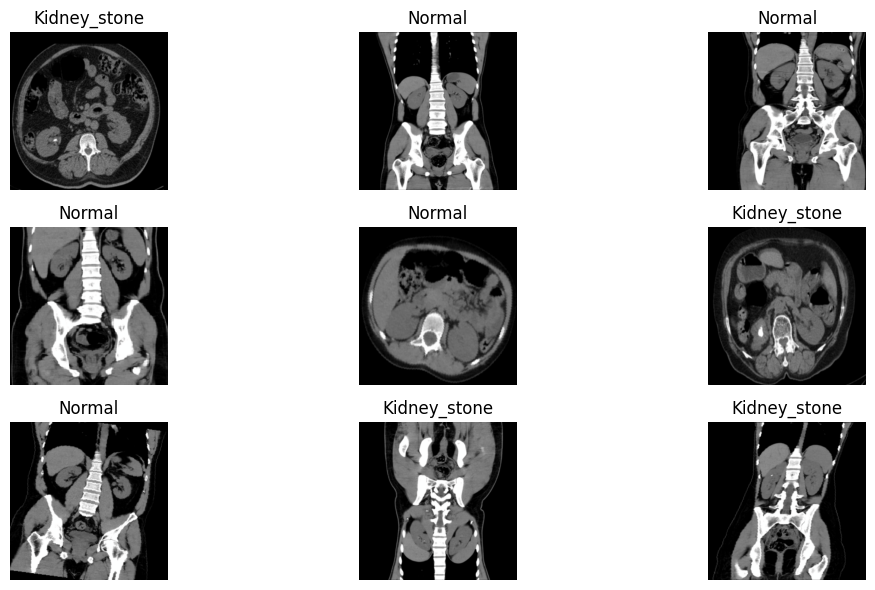

In [12]:
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow(images[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()

---

## 3. Model Classes & Architecture Selection

This section imports custom neural network classes and sets up the model selection mechanism.

You can choose from the following model architectures:

**Available options**: `"inception_v3"`, `"xception"`, `"inception_resnet_v2"`, `"stacked_ensemble"`


**Note**: The models will attempt to use pre-trained weights (if available). These are stored at  `"models/"`

In [13]:
from architectures import CustomClassifier, FeatureExtractionModel, StackedEnsembleNet

In [15]:
# MODEL SELECTION - CHANGE THIS VARIABLE TO SWITCH MODELS
MODEL_TYPE = "stacked_ensemble" 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # CUDA :D

# Model Loading based on the selected MODEL_TYPE
if MODEL_TYPE == "stacked_ensemble":
    # StackedEnsembleNet - combines InceptionV3, InceptionResNetV2, and Xception
    model = StackedEnsembleNet(device)
    model_name = 'stacked_ensemble_meta_learner.pth'
    info_name = 'stacked_ensemble_info.pth' 
    arch_name = 'StackedEnsembleNet'
    input_features = 6  # This input is for the meta-learner (3 models × 2 outputs)
    
    # Meta-learner weights loading
    model_path = f'models/{model_name}'
    if os.path.exists(model_path):
        try:
            model.meta_learner.load_state_dict(torch.load(model_path, map_location=device))
            print(f"✅ StackedEnsembleNet meta-learner weights loaded successfully.")
        except:
            print(f"⚠️ StackedEnsembleNet meta-learner architecture mismatch, starting from scratch.")
    else:
        print(f"❌ No saved StackedEnsembleNet meta-learner found. Starting from scratch.")
    
    print("✅ Using StackedEnsembleNet (InceptionV3 + InceptionResNetV2 + Xception)")

elif MODEL_TYPE == "xception":
    try:
        backbone = timm.create_model('xception', num_classes=0)
        input_features = backbone.num_features
        model_name = 'xception_kidney_stone_model.pth'
        info_name = 'xception_model_info.pth'
        arch_name = 'Xception_CustomClassifier'
        print("✅ Using Xception from timm")
    except Exception as e:
        print(f"⚠️ Xception not available ({e}), falling back to Inception V3")
        MODEL_TYPE = "inception_v3"  # Am using inception V3 as a fallback

elif MODEL_TYPE == "inception_resnet_v2":
    try:
        backbone = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=0)
        input_features = backbone.num_features
        model_name = 'inceptionresnetv2_kidney_stone_model.pth'
        info_name = 'inceptionresnetv2_model_info.pth'
        arch_name = 'InceptionResNetV2_CustomClassifier'
        print("✅ Using InceptionResNetV2 from timm")
    except Exception as e:
        print(f"⚠️ InceptionResNetV2 not available ({e}), falling back to Inception V3")
        MODEL_TYPE = "inception_v3"  # Am using inception V3 as a fallback

# Inception V3
if MODEL_TYPE != "xception" and MODEL_TYPE != "inception_resnet_v2" and MODEL_TYPE != "stacked_ensemble":
    backbone = models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT, aux_logits=True)
    backbone.fc = nn.Identity()
    backbone.AuxLogits.fc = nn.Identity()
    input_features = 2048
    model_name = 'inception_v3_kidney_stone_model.pth'
    info_name = 'inception_v3_model_info.pth'
    arch_name = 'Inception_v3_CustomClassifier'
    print("✅ Using Inception V3")

# This is for when using a single model.
# The model is initialized with the custom classifier with loaded weights
# and the backbone is frozen for feature extraction.
if MODEL_TYPE != "stacked_ensemble":
    # Layers are being frozen. Will be unlocked during training, depending on the training strategy.
    for param in backbone.parameters():
        param.requires_grad = False

    # Initializing the model
    custom_classifier = CustomClassifier(input_features=input_features)
    model = FeatureExtractionModel(backbone, custom_classifier)
    model = model.to(device)

    # Weights loading
    model_path = f'models/{model_name}'
    if os.path.exists(model_path):
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"✅ {arch_name} model weights loaded successfully.")
        except:
            print(f"⚠️ {arch_name} model architecture mismatch, starting from scratch.")
    else:
        print(f"❌ No saved {arch_name} model found. Starting from scratch.")

   📋 InceptionV3 weights loaded
   📋 InceptionResNetV2 weights loaded


c:\Users\HP\Desktop\SEN-D\.venv\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


   📋 Xception weights loaded
✅ StackedEnsembleNet initialized with 3 base models
✅ StackedEnsembleNet meta-learner weights loaded successfully.
✅ Using StackedEnsembleNet (InceptionV3 + InceptionResNetV2 + Xception)


Check if the model was loaded successfully by running this cell

In [16]:
print(f"\nModel Architecture: {arch_name}")
if MODEL_TYPE == "stacked_ensemble":
    print(f"- Base Models: {len(model.base_models)} (InceptionV3, InceptionResNetV2, Xception)")
    print(f"- Meta-learner: 6 → 512 → Dropout(0.2) → 128 → 2")
    print(f"- Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"- Total parameters: {sum(p.numel() for p in model.meta_learner.parameters()):,} (meta-learner only)")
else:
    print(f"- Frozen backbone for feature extraction (features: {input_features})")
    print(f"- Custom classifier: {input_features} → 256 → BN → Dropout → 128 → BN → 2")
    print(f"- Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model Architecture: StackedEnsembleNet
- Base Models: 3 (InceptionV3, InceptionResNetV2, Xception)
- Meta-learner: 6 → 512 → Dropout(0.2) → 128 → 2
- Total trainable parameters: 69,506
- Total parameters: 69,506 (meta-learner only)


---

## 4. Training Configuration & Model Training

This section sets up the optimizer, loss function, and initiates the training process for the selected model architecture.

In [17]:
learning_rate = 0.001
if MODEL_TYPE == "stacked_ensemble":
    learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Used when training the unfrozen model.

In [18]:
def train_model(EPOCHS, step_lr=False):
  for epoch in range(EPOCHS):
      model.train()
      running_loss = 0.0
      correct, total = 0, 0

      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      if step_lr == True:
        scheduler.step()
      print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%", flush=True)

Run the following cell to begin training the model.

**Note**: For optimal performance, it is recommended to use a CUDA-compatible GPU. You can also use Google Colab or a cloud-based environment.

In [ ]:
META_LAYER_EPOCHS = 5
END_LAYER_EPOCHS = 20
FULL_LAYER_EPOCHS = 5

if MODEL_TYPE == "stacked_ensemble":
    train_model(META_LAYER_EPOCHS)
else:
    train_model(END_LAYER_EPOCHS)

    for param in backbone.parameters():
        param.requires_grad = True

    print(f"- Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    train_model(FULL_LAYER_EPOCHS, step_lr=True)

---

## 5. Model Testing & Performance Evaluation

Evaluate the trained model using a variety of performance metrics and visualizations to assess accuracy, loss, and overall effectiveness.

In [19]:
model.eval()
all_predictions = []
all_labels = []

print("Evaluating model on test set...")

count = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        count += 1
        print(f"Processed {count * BATCH_SIZE} images", end='\r')

# NumPy :D
y_true = np.array(all_labels)
y_pred = np.array(all_predictions)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Statistics
accuracy = (tp + tn) / (tn + fn + tp + fp)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
sensitivity_recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# Matthews Correlation Coefficient (MCC) / Phi Coefficient
denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
mcc = ((tp * tn) - (fp * fn)) / denominator if denominator != 0 else 0

# F1 Score
f1_score = (2 * precision * sensitivity_recall) / (precision + sensitivity_recall) if (precision + sensitivity_recall) > 0 else 0

# Summary
print(f"\nSummary:")
print(f"{'='*60}")
print(f"Model: {arch_name}")
print(f"Test Dataset: {len(y_true)} images")
print(f"Classes: {class_names}")
print(f"")
print(f"Results:")
print(f"  • Accuracy: {100 * accuracy:.4f}%")
print(f"  • Precision: {100 * precision:.4f}%")
print(f"  • Sensitivity/Recall: {100 * sensitivity_recall:.4f}%")
print(f"  • F1-Score: {100 * f1_score:.4f}%")
print(f"  • Matthews Correlation Coefficient: {100 * mcc:.4f}%")
print(f"{'='*60}")

Evaluating model on test set...
Processed 1536 images
Summary:
Model: StackedEnsembleNet
Test Dataset: 1508 images
Classes: ['Kidney_stone', 'Normal']

Results:
  • Accuracy: 98.7401%
  • Precision: 98.5714%
  • Sensitivity/Recall: 98.9570%
  • F1-Score: 98.7638%
  • Matthews Correlation Coefficient: 97.4800%


Run the following cell to plot the generated metrics, as well as the confusion matrix based on the evaluation results.


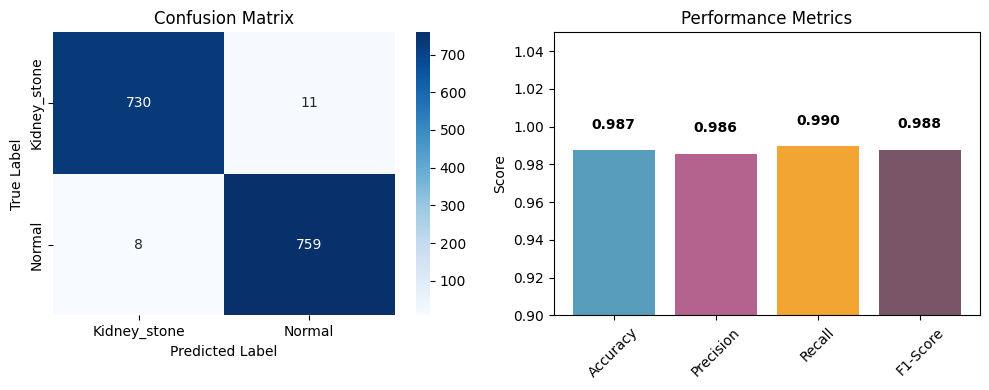

In [20]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 4))

# Confusion Matrix Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics Bars
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, sensitivity_recall, f1_score]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#592941']

bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.ylim(0.9, 1.05)

# Value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

## 6. Model Saving & Export

Save the trained model weights and configuration for future use.

**Note**: Running this will overwrite any previously saved weights.

In [ ]:
os.makedirs('models', exist_ok=True)

# Model saving
if MODEL_TYPE == "stacked_ensemble":
    # For ensemble, only the meta-learner weights are saved
    torch.save(model.meta_learner.state_dict(), f'models/{model_name}')
    print(f"✅ {arch_name} Meta-learner saved successfully!")
else:
    # For single models, complete model weights are saved
    torch.save(model.state_dict(), f'models/{model_name}')
    print(f"✅ {arch_name} Model saved successfully!")

print(f"📁 Model weights: models/{model_name}")

---

## 7. Google Colab Download (Optional)

Run this cell to download the trained model files when running in Google Colab environment.

**Note**: This will only download the currently selected model.

In [ ]:
try:
    from google.colab import files

    print("Downloading model files...")

    files.download(f'models/{model_name}')

    print("Check your Downloads folder for:")
    print(f"   - {model_name}")
    print(f"   - {info_name}")

except ImportError:
    print("⚠️  Not running in Google Colab - skipping download")
except Exception as e:
    print(f"❌ Download failed: {e}")
    print("💡 Alternative: 2Use the file browser on the left to download manually")